# Industrial Meter Reading with OpenVINO
In many industries, analog gauges are monitored manually, thus posing problems, especially in large facilities where gauges are often placed in hard-to-access or dangerous locations. This notebook demonstrait reading meters with TensorFlow models and OpenVINO runtime.

![](https://github.com/ashish-2005/Industrial-Meter-Reading/assets/71766106/00b590f8-53e4-4fe4-9860-ebb0d64a1f1c)

Whole process can broadly devided into three parts :


1. Detection : Detecting meters in the input image or frame.
2. Segmentation : Creating segmentation mask to get pointer and scale
3. Reading : Finding position of pointer and scale and calculating readings


We have used Efficientdet-d0 and UNET as detector and segmentor respectively. Both models are trained on PaddlePaddle meter dataset. All the training approch and code, training APIs used, TensorFlow inference and motivation for model selection and refrences can be found at this [github repository](https://github.com/ashish-2005/GSoC23-TF-meter-reader/tree/master).



### Download trained model and test dataset

Bellow cell will download the trained model and the test dataset

In [ ]:
!pip install openvino-dev

In [ ]:
# download detector and segmentor
!gdown 1273sbQazK8ZAWBbeKLzvesh5d_d1C6tV
!gdown 1Et6x-2I5-yxhv8IMR3pwG6PkNGpTlApt

!unzip unet_segmentor.zip
!unzip efficientdet_detector.zip

In [ ]:
# download test dataset
import os

det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'
seg = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_seg.tar.gz'
test = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_test.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [test,seg]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

#### Importing Dependencies

In [ ]:
import pathlib
import math
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

### Generating OpenVINO IR
Below cells will convert model from Tensorflow's SavedModel format to OpenVINO' Intermidiate representation(IR).

OpenVINO-IR consists of one XML file, which is a standardized file format for representing neural network models optimized for use with Intel hardware. This XML file can also be loaded into any platform with an OpenVINO inference engine and Intel hardware for further deployment.

In [ ]:
# Creating Paths and folders
IR_PATH = pathlib.Path('IR')
DETECTOR_IR_PATH = pathlib.Path('IR/detector_IR')
SEGMENTOR_IR_PATH = pathlib.Path('IR/segmentor_IR')

IR_PATH.mkdir(exist_ok=True)
DETECTOR_IR_PATH.mkdir(exist_ok=True)
SEGMENTOR_IR_PATH.mkdir(exist_ok=True)

In [ ]:
# Convert TF-SavedModel to OV-IR
from openvino.tools import mo
from openvino.runtime import serialize

model_ir = mo.convert_model(saved_model_dir='efficientdet_detector')
DETECTOR_XML_PATH = DETECTOR_IR_PATH / 'detector.xml'
serialize(model_ir,str(DETECTOR_XML_PATH))

model_ir = mo.convert_model(saved_model_dir='unet_segmentor')
SEGMENTOR_XML_PATH = SEGMENTOR_IR_PATH / 'segmentor.xml'
serialize(model_ir,str(SEGMENTOR_XML_PATH))

### Inference with OpenVINO runtime
Once the models are converted to OpenVINO-IR it can be used in any platform with OpenVINO inference engine.

In [ ]:
from openvino.runtime import Core

core = Core()
# read converted model
detector_ir = core.read_model(model=DETECTOR_XML_PATH)
segmentor_ir = core.read_model(model=SEGMENTOR_XML_PATH)

# load model on CPU device
detector = core.compile_model(detector_ir, 'CPU')
segmentor = core.compile_model(segmentor_ir, 'CPU')

In [ ]:
# meter configs
METER_SHAPE = [512, 512]
CIRCLE_CENTER = [256, 256]
CIRCLE_RADIUS = 250
PI = math.pi
RECTANGLE_HEIGHT = 120
RECTANGLE_WIDTH = 1570
TYPE_THRESHOLD = 40

METER_CONFIG = [{
    'scale_interval_value': 25.0 / 50.0,
    'range': 25.0,
    'unit': "(MPa)"
}, {
    'scale_interval_value': 1.6 / 32.0,
    'range': 1.6,
    'unit': "(MPa)"
}]


SEG_LABEL = {'background': 0, 'pointer': 1, 'scale': 2}

In [ ]:
# all the utility function required
def roi_crop(image, results, scale_x, scale_y):
    """
    Crop the area of detected meter of original image

    Param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    Retuns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations

    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result
        ymin, xmin, ymax, xmax = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
        sub_img = image[ymin:(ymax + 1), xmin:(xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc

def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Preprocessing the input data for segmentation task

    Param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g [heigh,width]
        interp (int)：the interp method for image reszing

    Retuns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization

    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=interp)
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list


def erode(seg_results, erode_kernel):
    """
    Erode the segmentation result to get the more clear instance of pointer and scale

    Param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    Return：
        eroded_results (list[dict])： the lab map of eroded_results

    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results


def circle_to_rectangle(seg_results):
    """
    Switch the shape of label_map from circle to rectangle

    Param：
        seg_results (list[dict])：segmentation results

    Return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH

                # The radius of meter circle will be mapped to the height of rectangle image
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters


def rectangle_to_line(rectangle_meters):
    """
    Switch the dimension of rectangle label map from 2D to 1D

    Param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    Return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL['pointer']:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL['scale']:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers


def mean_binarization(data_list):
    """
    Binarize the data

    Param：
        data_list (list[np.array])：input data

    Return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list


def locate_scale(line_scales):
    """
    Find location of center of each scale

    Param：
        line_scales (list[np.array])：the list of binaried scales value

    Return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations


def locate_pointer(line_pointers):
    """
    Find location of center of pointer

    Param：
        line_scales (list[np.array])：the list of binaried pointer value

    Return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0 :
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    Match location of pointer and scales

    Param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    Return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales

    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations,
                                                pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = i + (pointer_location - scale_location[i]) / (scale_location[i + 1] - scale_location[i] + 1e-05) + 1
        result = {'num_scales': num_scales, 'pointed_scale': pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    Calculate the value of meter according to the type of meter

    Param：
        pointed_scales (list[list])：predicted number of scales

    Return：
        readings (list[float])： the list of values read from meter

    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find the type of meter according the total number of scales
        if pointed_scale['num_scales'] > TYPE_THRESHOLD:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[0]['scale_interval_value']
        else:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[1]['scale_interval_value']
        readings.append(reading)
    return readings

In [ ]:
def plot_result(img,readings,bboxs):
    '''
    Parameters
        img (np.ndarray) : image
        readings (array) : reading of detected meters
        bboxs(np.ndarray): BBOXs of detected meters

    Returns
        img (np.ndarray) : image with BBOX and readings
    '''
    for i in range(len(readings)):
        reading = readings[i]
        if reading >= 0:
            ymin,xmin,ymax,xmax = bboxs[i]

            img = cv2.rectangle(img,
                                (xmin,ymin),
                                (xmax,ymax),
                                (255, 51, 204),
                                3)
            img = cv2.rectangle(img,
                                (xmin,ymin),
                                (xmin+145,ymin+50),
                                (255, 51, 204),
                                -1)
            img = cv2.putText(img,
                            f'{reading:.3f}',
                            (xmin+5,ymin+40),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.5,
                            (255,255,255),
                            2,
                            cv2.LINE_AA)
    return img

In [ ]:
def pipeline(frame):
    '''
    Complete pipeline
    Image --> Detection --> Cropping --> Semantic-Segmentation --> Reading --> Plotting

    Parameters
        frame (np.ndarray) : image

    Retursn
        plotted_image (np.ndarray) : image with detection box and reading
    '''


    # Getting Detection BBOXs
    frame = cv2.resize(frame,(1920,1080),cv2.INTER_AREA)
    prediction = detector(frame.reshape(1,1080,1920,3))
    result_ratio = prediction['detection_boxes'][0]
    scores = prediction['detection_scores'][0]
    selected_rr = []

    for i in range(len(scores)):
        if scores[i]>0.5:
            selected_rr.append(result_ratio[i])
        else:
            break
    try:
        results = np.multiply(selected_rr,[1082,1920,1082,1920]).astype(np.int64)
    except:
        return(frame)

    # Cropping Meters
    roi_imgs,loc = roi_crop(frame,results,1,1)

    # Preprocess uneven cropped imgs to 256,256
    crop_img = []
    for roi_img in roi_imgs:
        resized = cv2.resize(roi_img,(256,256),cv2.INTER_AREA)
        crop_img.append(resized)

    if len(crop_img) > 0:
        # Getting Segmentation Maps
        pred_seg = segmentor(np.array(crop_img))[segmentor.output(0)]
        processed_seg = []
        for i in pred_seg:
            processed_seg.append(cv2.resize(i,(512,512),cv2.INTER_AREA))
        pred = np.argmax(processed_seg,axis=3)

        # Getting Reading from predicted Maps
        pred = erode(pred,2)
        rectangle_meters = circle_to_rectangle(pred)
        line_scales, line_pointers = rectangle_to_line(rectangle_meters)
        binaried_scales = mean_binarization(line_scales)
        binaried_pointers = mean_binarization(line_pointers)
        scale_locations = locate_scale(binaried_scales)
        pointer_locations = locate_pointer(binaried_pointers)
        pointed_scales = get_relative_location(scale_locations, pointer_locations)
        meter_readings = calculate_reading(pointed_scales)

        # Plotting reading and BBOXs on image
        plotted_img = plot_result(frame,meter_readings,results)

    else:
        plotted_img = frame
    return plotted_img

In [ ]:
img = cv2.imread('meter_test/20190822_110.jpg')

In [ ]:
result = pipeline(img)

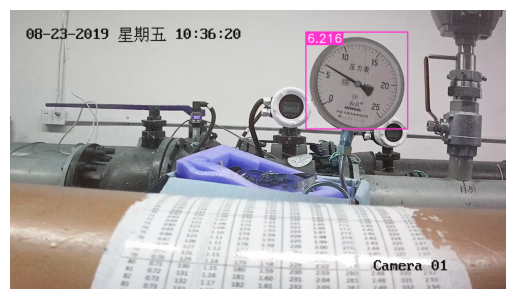

In [ ]:
plt.imshow(result);plt.axis(False);plt.show()